<a href="https://colab.research.google.com/github/SquirrelLover/FearNet-Implementation/blob/main/FearNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementation of a Fearnet Variation

Authors: Brady Gho, Lucy Wu

Source: https://arxiv.org/abs/1711.10563

Created on July 25, 2024. Last edited August 2, 2024

# Defining Imports and Meta-parameters

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np

import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torch.distributions as dist
from torchvision.models import resnet50, ResNet50_Weights

from collections import defaultdict

import pdb

import gc

import math

In [ ]:
# Define meta-Parameters
Mini_batch = 100
Dropout = 0.5
Autoencoder_Hidden_Dims = np.array([1024, 512])
mPFC_Classifier_Dims = [100]
Classifier_Dims = np.array([2048, 600, 100])
Lambda_Values = [1e4, 1, 0.1]
Input_Dim = 2048
Learning_Rate = 5e-4
Mem_Cons_Epochs = 10
mPFC_Base_Epochs = 20
BLA_Epochs = 10
sleep_frequency = 5

torch.manual_seed(42) # seed set for reproducibility

# Loading and Processing Data

Files already downloaded and verified
Files already downloaded and verified
Train Loader Images:


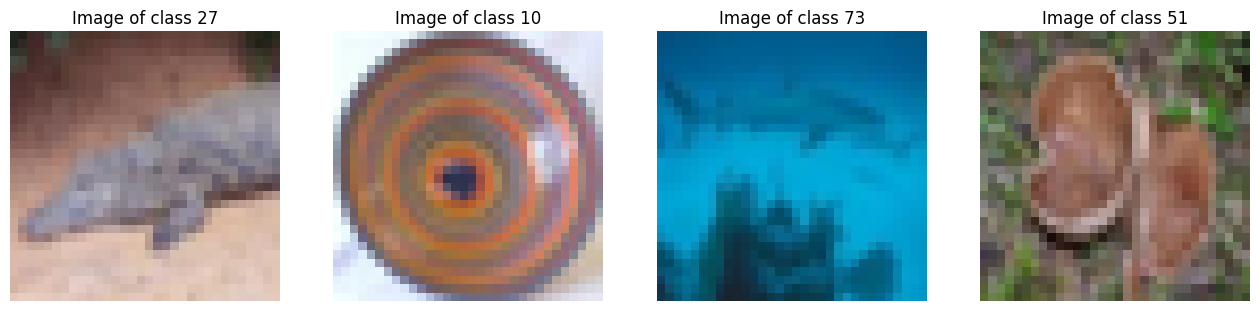

In [ ]:
# Load Dataset (CIFAR-100)

transform = transforms.Compose([
    transforms.ToTensor(),
    # insert more transformations of data i.e. normalization
])

train_data = torchvision.datasets.CIFAR100(root='./data', train=True, transform = transform, download = True)
test_data = torchvision.datasets.CIFAR100(root='./data', train=False, transform = transform, download = True)

train_loader = DataLoader(train_data, batch_size = Mini_batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size = Mini_batch, shuffle=False)

# view a couple of sample images to make sure they are loaded

def display_img_examples(loader):
  images, labels = next(iter(loader))
  images = images.cpu().detach().numpy()
  plt.figure(figsize=(16, 4))
  for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    plt.axis('off')
    plt.title(f"Image of class {labels[i].item()}")
  plt.show()

print("Train Loader Images:")
display_img_examples(train_loader)

In [ ]:
class FeatureDataset(Dataset):
    def __init__(self, features=torch.zeros((0, 2048), dtype=torch.float32), labels=torch.zeros(0)):
        self.features = features
        self.labels = labels.long()

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label

    def add_features(self, new_features, new_labels):
        self.features = torch.cat((self.features, new_features), dim=0)
        self.labels = torch.cat((self.labels, new_labels), dim=0)

In [ ]:
def dataloader_to_dataset(dataloader):
    # Initialize lists to store features and labels
    all_features = []
    all_labels = []

    # Process all batches
    for features, labels in dataloader:
        all_features.append(features)
        all_labels.append(labels)

    # Concatenate all features and labels
    all_features = torch.cat(all_features)
    all_labels = torch.cat(all_labels)

    # Create a new FeatureDataset from the concatenated features and labels
    dataset = FeatureDataset(all_features, all_labels)
    return dataset

In [ ]:
# Resnet processing

resnet = resnet50(pretrained=True)
resnet.eval()

resnet_feature_extractor = nn.Sequential(*list(resnet.children())[:-1])

In [ ]:
# pass data through Resnet processing
class CIFAR100FeatureDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, label

# training data
num_images = len(train_data)
feature_vectors = torch.zeros((num_images, 2048))
labels = torch.zeros(num_images)

feature_dataset = CIFAR100FeatureDataset(train_data)
feature_loader = DataLoader(feature_dataset, batch_size=Mini_batch, shuffle=False)

with torch.no_grad():
    for i, (images, labels_batch) in enumerate(feature_loader):
        images = images
        labels_batch = labels_batch
        features_batch = resnet_feature_extractor(images).squeeze()
        start_index = i * Mini_batch
        end_index = start_index + features_batch.shape[0]
        feature_vectors[start_index:end_index] = features_batch
        labels[start_index:end_index] = labels_batch

feature_vectors = torch.tensor(feature_vectors, dtype=torch.float32)
labels = torch.tensor(labels).long()

print("Training features shape:", feature_vectors.shape)
print("Training labels shape:", labels.shape)

# testing data
num_images = len(test_data)
test_feature_vectors = torch.zeros((num_images, 2048))
test_labels = torch.zeros(num_images)

test_feature_dataset = CIFAR100FeatureDataset(test_data)
test_feature_loader = DataLoader(test_feature_dataset, batch_size=Mini_batch, shuffle=False)

with torch.no_grad():
    for i, (images, labels_batch) in enumerate(test_feature_loader):
        features_batch = resnet_feature_extractor(images).squeeze()
        start_index = i * Mini_batch
        end_index = start_index + features_batch.shape[0]
        test_feature_vectors[start_index:end_index] = features_batch
        test_labels[start_index:end_index] = labels_batch

test_feature_vectors = torch.tensor(test_feature_vectors, dtype=torch.float32)
test_labels = torch.tensor(test_labels).long()

print("Test features shape:", test_feature_vectors.shape)
print("Test labels shape:", test_labels.shape)

Training features shape: torch.Size([50000, 2048])
Training labels shape: torch.Size([50000])
Test features shape: torch.Size([10000, 2048])
Test labels shape: torch.Size([10000])


# Evaluate the Performance of Resnet on CIFAR-100

In [ ]:
resnet_test = resnet50(pretrained=True)
num_features = resnet_test.fc.in_features
resnet_test.fc = nn.Linear(num_features, 100)

In [ ]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_test.parameters(), lr=0.001)

# training function
def training_step(model, data_loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for images, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(data_loader)
    return average_loss

# calculate accuracy
def calc_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# training
num_epochs = 30
for epoch in range(num_epochs):
    avg_loss = training_step(resnet_test, train_loader, criterion, optimizer)
    accuracy = calc_accuracy(resnet_test, test_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}, Accuracy: {accuracy}%")

In [ ]:
# test accuracy

def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Evaluate the model
test_accuracy = evaluate_model(resnet_test, test_loader)
print(f'Test Accuracy of the model on the 10000 test images: {test_accuracy:.2f}%')

# Hippocampus Implementation

In [ ]:
# define HC

class HC(nn.Module):
  def __init__(self, classifier_dims = Classifier_Dims, learning_rate= Learning_Rate, p_dropout=Dropout):
    super(HC, self).__init__()

    self.short_term_memory = FeatureDataset()

    self.classifier_layers = []
    self.current_dim = classifier_dims[0]

    if len(classifier_dims)!=1:
      # Avoid dropping out the first layer of processing and output layer
      self.classifier_layers.append(nn.Linear(self.current_dim, classifier_dims[0]))
      self.classifier_layers.append(nn.ReLU())

      for i in range(1, len(classifier_dims)-1):
        self.hidden_dim = classifier_dims[i]
        self.classifier_layers.append(nn.Linear(self.current_dim, self.hidden_dim))
        self.classifier_layers.append(nn.ReLU())
        self.classifier_layers.append(nn.Dropout(p=p_dropout))
        self.current_dim = self.hidden_dim

    self.classifier_layers.append(nn.Linear(self.current_dim, classifier_dims[len(classifier_dims)-1]))

    self.classifier = nn.Sequential(*self.classifier_layers)

    # Using Adam Optimizer
    self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)
    self.CrossEntropyLoss = nn.CrossEntropyLoss()

  def forward(self, x, y = None, is_storing = False):
    if (is_storing):
      features = x
      labels = y
      self.short_term_memory.add_features(x, y)
    class_logits = self.classifier(x)
    return class_logits

  def clear_memory(self):
    memory = self.short_term_memory
    self.short_term_memory = FeatureDataset(features=torch.tensor([]), labels=torch.tensor([]))
    return memory

  def training_step(self, dataloader):
    total_loss = 0

    self.train()
    optimizer = self.optimizer

    for features, targets in dataloader:
      optimizer.zero_grad()

      class_logits = self.forward(features, targets, is_storing=True)
      loss = self.CrossEntropyLoss(class_logits, targets)

      loss.backward()
      optimizer.step()

      total_loss += loss

    return (total_loss / (len(dataloader) * dataloader.batch_size))

  def calc_accuracy(self, dataloader):
    total_correct = 0

    self.eval()
    with torch.no_grad():
      for features, targets in dataloader:
        predictions = self.forward(features, targets, is_storing=False)
        predictions = torch.argmax(predictions, dim=1)

        correct = (predictions == targets).sum().item()
        total_correct += correct

    return (total_correct / (len(dataloader) * dataloader.batch_size))*100

  def calculate_average_examples_per_class(self):
    class_counts = defaultdict(int)

    for label in self.short_term_memory.labels:
      class_counts[label.item()] += 1

    total_examples = sum(class_counts.values())
    total_classes = len(class_counts)

    average_examples_per_class = math.ceil(total_examples / total_classes) if total_classes > 0 else 0
    return average_examples_per_class


# Pre-frontal Cortex  Implementation

In [ ]:
# define mPFC (long term)

class mPFC(nn.Module):
  def __init__(self, input_dim=Input_Dim, autoencoder_hidden_dims = Autoencoder_Hidden_Dims, classifier_dims = mPFC_Classifier_Dims, lambda_values=Lambda_Values, learning_rate=Learning_Rate):
    super(mPFC, self).__init__()
    # encoder
    self.encoder_layers = []
    self.current_dim = input_dim
    self.encoder_layers.append(nn.ELU())
    for hidden_dim in autoencoder_hidden_dims:
      self.encoder_layers.append(nn.Linear(self.current_dim, hidden_dim))
      self.encoder_layers.append(nn.ELU())
      self.current_dim = hidden_dim
    self.encoder = nn.Sequential(*self.encoder_layers)

    # decoder
    self.decoder_layers = []
    self.hidden_dims_reversed = list(autoencoder_hidden_dims[::-1])
    for hidden_dim in self.hidden_dims_reversed:
      self.decoder_layers.append(nn.Linear(self.current_dim, hidden_dim))
      self.decoder_layers.append(nn.ELU())
      self.current_dim = hidden_dim
    self.decoder_layers.append(nn.Linear(self.current_dim, input_dim))
    self.decoder_layers.append(nn.ELU())
    self.decoder = nn.Sequential(*self.decoder_layers)

    #classifier
    self.current_dim = autoencoder_hidden_dims[-1]
    self.classifier_layers= []

    if len(classifier_dims) != 1:
      self.classifier_layers.append(nn.Linear(self.current_dim, classifier_dims[0]))
      self.classifier_layers.append(nn.ELU())
      self.current_dim = classifier_dims[0]

      for i in range(1, len(classifier_dims)-1):
        self.hidden_dim = classifier_dims[i]
        self.classifier_layers.append(nn.Linear(self.current_dim, hidden_dim))
        self.classifier_layers.append(nn.ELU())
        self.classifier_layers.append(nn.Dropout(p=Dropout))
        self.current_dim = hidden_dim

    self.classifier_layers.append(nn.Linear(self.current_dim, classifier_dims[len(classifier_dims)-1]))

    self.classifier = nn.Sequential(*self.classifier_layers)

    # lambda
    self.lambda_values = torch.tensor(lambda_values if lambda_values else [1.0] * len(autoencoder_hidden_dims), dtype=torch.float32)

    # optimizer
    self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    #session number
    self.class_means = defaultdict(list)
    self.class_covariances = defaultdict(list)

    self.input_dim = input_dim

  def encoder_forward(self, x):
    encoder_intermediates = [x]
    for layer in self.encoder:
      x = layer(x)
      encoder_intermediates.append(x)
    encoded = encoder_intermediates[-1]
    return encoded, encoder_intermediates

  def decoder_forward(self, x):
    decoder_intermediates = [x]
    for layer in self.decoder:
      x = layer(x)
      decoder_intermediates.append(x)
    pseudo_img = decoder_intermediates[-1]
    return pseudo_img, list(decoder_intermediates[::-1])

  def classify(self, x):
    class_logits = self.classifier(x)
    return class_logits

  def compute_loss(self, class_logits, targets, encoder_intermediates, decoder_intermediates):
    # classification loss
    classification_loss = nn.CrossEntropyLoss()(class_logits, targets)

    # reconstruction loss with lambda weighting
    reconstruction_loss = 0
    for i in range(len(self.lambda_values)):
      encoder_hidden = encoder_intermediates[i]
      decoder_hidden = decoder_intermediates[i]
      diff = encoder_hidden - decoder_hidden
      squared_diff = diff.pow(2)
      layer_loss = squared_diff.sum()
      reconstruction_loss += self.lambda_values[i] * layer_loss

    # total loss
    total_loss = classification_loss + reconstruction_loss

    return classification_loss, reconstruction_loss, total_loss

  def training_step(self, data_loader):
    self.train()

    total_classification_loss = 0
    total_reconstruction_loss = 0
    total_total_loss = 0

    for x, targets in data_loader:
      # forward pass
      encoded, encoder_intermediates = self.encoder_forward(x)
      pseudo_img, decoder_intermediates = self.decoder_forward(encoded)
      class_logits = self.classify(encoded)

      # compute losses
      classification_loss, reconstruction_loss, total_loss = self.compute_loss(
        class_logits, targets, encoder_intermediates, decoder_intermediates
      )

      # zero gradients
      self.optimizer.zero_grad()

      # backward pass
      classification_loss.backward(retain_graph=True)
      classifier_grads = {name: param.grad.clone() for name, param in self.classifier.named_parameters()}
      reconstruction_loss.backward(retain_graph=True)
      decoder_grads = {name: param.grad.clone() for name, param in self.decoder.named_parameters()}
      total_loss.backward()
      encoder_grads = {name: param.grad.clone() for name, param in self.encoder.named_parameters()}

      # optimizer
      encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=self.optimizer.defaults['lr'])
      encoder_optimizer.step()
      classifier_optimizer = optim.Adam(self.classifier.parameters(), lr=self.optimizer.defaults['lr'])
      classifier_optimizer.step()
      decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=self.optimizer.defaults['lr'])
      decoder_optimizer.step()

      # update parameters
      for name, param in self.classifier.named_parameters():
        if param.grad is not None:
          param.grad.data = classifier_grads[name].data
      for name, param in self.decoder.named_parameters():
        if param.grad is not None:
          param.grad.data = decoder_grads[name].data
      for name, param in self.encoder.named_parameters():
        if param.grad is not None:
          param.grad.data = encoder_grads[name].data

      # add losses to total
      total_classification_loss += classification_loss.item()
      total_reconstruction_loss += reconstruction_loss.item()
      total_total_loss += total_loss.item()

    # average loss
    average_classification_loss = total_classification_loss / len(data_loader)
    average_reconstruction_loss = total_reconstruction_loss / len(data_loader)
    average_total_loss = total_total_loss / len(data_loader)

    return average_classification_loss, average_reconstruction_loss, average_total_loss

  def consolidate_statistics(self):
    # compute the average mean vector and covariance matrix for each class
    for label in self.class_means:
      if isinstance(self.class_means[label], list) and len(self.class_means[label]) > 0:
        means = torch.stack(self.class_means[label])
        covariances = torch.stack(self.class_covariances[label])

        # Average the mean vectors and covariance matrices
        consolidated_mean = means.mean(dim=0)
        consolidated_covariance = covariances.mean(dim=0)

        # Update the consolidated statistics
        self.class_means[label] = []
        self.class_means[label].append(consolidated_mean)
        self.class_covariances[label] = []
        self.class_covariances[label].append(consolidated_covariance)

      elif isinstance(self.class_means[label], torch.Tensor):
        # If the statistics are already in tensor form, no need to stack
        consolidated_mean = self.class_means[label]
        consolidated_covariance = self.class_covariances[label] if isinstance(self.class_covariances[label], torch.Tensor) else torch.zeros_like(consolidated_mean)

        # Update the consolidated statistics
        self.class_means[label] = []
        self.class_means[label].append(consolidated_mean)
        self.class_covariances[label] = []
        self.class_covariances[label].append(consolidated_covariance)

  def compute_covariance_matrix(self, features):
    # Compute mean vector and covariance matrix
    mean_vector = features.mean(dim=0)
    centered_features = features - mean_vector
    covariance_matrix = torch.mm(centered_features.t(), centered_features) / (features.size(0) - 1)

    # Ensure covariance matrix is positive definite using Cholesky decomposition
    epsilon = 1e-5
    attempts = 0
    max_attempts = 10
    while attempts < max_attempts:
        try:
            # Attempt Cholesky decomposition
            torch.linalg.cholesky(covariance_matrix)
            break
        except RuntimeError:
            # If decomposition fails, add a larger epsilon to the diagonal
            epsilon *= 10
            covariance_matrix += epsilon * torch.eye(covariance_matrix.size(0))

        attempts += 1

    if attempts == max_attempts:
        raise ValueError("Covariance matrix could not be made positive definite")

    return covariance_matrix

  def generate_statistics(self, feature_vectors, labels):
    # Dictionary to hold features for each class
    class_features = defaultdict(list)

    # Organize features by class
    for i in range(len(labels)):
        label = labels[i].item()  # Ensure label is a scalar
        feature_vector = feature_vectors[i]

        # Append feature vector to the corresponding class list
        class_features[label].append(feature_vector)

    # Process each class
    for label, features in class_features.items():
        features = torch.stack(features)
        # Compute covariance matrix using the updated function
        covariance_matrix = self.compute_covariance_matrix(features)
        # Initialize lists for means and covariances if not already present
        if label not in self.class_means:
            self.class_means[label] = []
        if label not in self.class_covariances:
            self.class_covariances[label] = []

        # Compute mean vector for the class
        mean_vector = features.mean(dim=0)

        # Append mean vector and covariance matrix to class statistics
        self.class_means[label].append(mean_vector)
        self.class_covariances[label].append(covariance_matrix)

    # Consolidate the collected statistics
    self.consolidate_statistics()

  def pseudoimg_from_statistics(self, num_examples_per_class):
    self.eval()

    pseudo_examples = []
    pseudo_labels = []

    for label, mean_vector in self.class_means.items():
      if isinstance(mean_vector, torch.Tensor):
        covariance_matrix = self.class_covariances[label]

        # create a multivariate normal distribution
        mvn = dist.MultivariateNormal(mean_vector, covariance_matrix)

        # generate pseudo-examples
        examples = mvn.sample((num_examples_per_class,))
        labels = torch.full((num_examples_per_class,), label, dtype=torch.long)

        pseudo_examples.append(examples)
        pseudo_labels.append(labels)

    if len(pseudo_examples) == 0 or len(pseudo_labels) == 0:
      pseudo_examples = torch.empty((0, self.input_dim))
      pseudo_labels = torch.empty((0,), dtype=torch.long)
    else:
      pseudo_examples = torch.cat(pseudo_examples)
      pseudo_labels = torch.cat(pseudo_labels)

    return pseudo_examples, pseudo_labels

  def calculate_accuracy(self, data_loader):
    self.eval()
    correct = 0
    total = 0

    with torch.no_grad():
      for x, targets in data_loader:
        encoded, _ = self.encoder_forward(x)
        class_logits = self.classify(encoded)
        _, predicted = torch.max(class_logits.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        # print('l')
        # breakpoint()

    accuracy = 100 * correct / total
    return accuracy

mpfc = mPFC(Input_Dim, Autoencoder_Hidden_Dims, Classifier_Dims, [1e4, 1, 0.1], 5e-4)

# BLA Implementation

In [ ]:
# Define BLA

class BLA(nn.Module):

  def __init__(self, classifier_dims = Classifier_Dims, learning_rate= Learning_Rate, p_dropout=Dropout):
    super(BLA, self).__init__()

    self.classifier_layers = []
    self.current_dim = classifier_dims[0]

    if len(classifier_dims)!=1:
      # Avoid dropping out the first layer of processing and output layer
      self.classifier_layers.append(nn.Linear(self.current_dim, classifier_dims[0]))
      self.classifier_layers.append(nn.ReLU())

      for i in range(1, len(classifier_dims)):
        self.hidden_dim = classifier_dims[i]
        self.classifier_layers.append(nn.Linear(self.current_dim, self.hidden_dim))
        self.classifier_layers.append(nn.ReLU())
        self.classifier_layers.append(nn.Dropout(p=p_dropout))
        self.current_dim = self.hidden_dim

    self.classifier_layers.append(nn.Linear(self.current_dim, 1))

    self.classifier = nn.Sequential(*self.classifier_layers)

    # Using Adam Optimizer
    self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)


  def forward(self, x):
    class_logits = self.classifier(x)
    return class_logits

  def training_step(self, dataloader, HC, mPFC):
    total_loss = 0
    self.train()
    HC.eval()
    mPFC.eval()

    for features, labels in dataloader:
        HC_logits = []
        mPFC_logits = []

        # Forward pass for HC and mPFC models
        with torch.no_grad():
            HC_logits = HC.forward(features)
            encoded, _ = mPFC.encoder_forward(features)
            mPFC_logits = mPFC.classify(encoded)

        # Get the optimizer
        optimizer = self.optimizer
        optimizer.zero_grad()

        # Compute class probabilities from BLA
        class_logits = self.forward(features)
        class_prob = torch.sigmoid(class_logits)

        # Create target tensor based on source information
        BLA_target = labels.float().view(-1, 1)  # Convert source information to float tensor

        # Compute BLA loss
        BLA_loss = nn.BCELoss()(class_prob, BLA_target)

        # Backward pass and optimization
        BLA_loss.backward()
        optimizer.step()

        # Accumulate total loss
        total_loss += BLA_loss.item()

    return total_loss / len(dataloader)

  def calc_accuracy(self, dataloader):
    total_correct = 0

    self.eval()
    with torch.no_grad():
      for features, targets in dataloader:
        predictions = self.forward(features)
        predictions = torch.argmax(predictions, dim=1)

        correct = (predictions == targets).sum().item()
        total_correct += correct

    return (total_correct / (len(dataloader) * dataloader.batch_size))*100


Bla = BLA()

# Dual Memory System Model

In [ ]:
# base knowledge dataloader

def sort_by_class(feature_vectors, labels):
  # Sort labels and get the sorted indices
  sorted_labels, indices = torch.sort(labels)

  # Use the sorted indices to sort the feature vectors
  sorted_feature_vectors = feature_vectors[indices]

  return sorted_feature_vectors, sorted_labels

sorted_feature_vectors, sorted_labels = sort_by_class(feature_vectors, labels)
half = int(len(sorted_labels)/2)
base_dataset = FeatureDataset(sorted_feature_vectors[:half], sorted_labels[:half])
base_dataloader = DataLoader(base_dataset, batch_size=Mini_batch, shuffle=True)


In [ ]:
# dmsm

class DMSM(nn.Module):
  def __init__(self, input_dim=Input_Dim, autoencoder_dims = Autoencoder_Hidden_Dims, classifier_dims = Classifier_Dims, mpfc_classifier_dims = mPFC_Classifier_Dims, learning_rate=Learning_Rate, p_dropout=Dropout, mpfc_base_epochs = mPFC_Base_Epochs, lambda_values = Lambda_Values, dataloader = base_dataloader):
    super(DMSM, self).__init__()

    self.hc = HC(classifier_dims, learning_rate, p_dropout)
    self.bla = BLA(classifier_dims, learning_rate, p_dropout)
    self.mpfc = mPFC(input_dim, autoencoder_dims, mpfc_classifier_dims, lambda_values, learning_rate)
    self.mpfc_base_epochs = mpfc_base_epochs
    self.dataloader = base_dataloader

  def base_knowledge(self):
    for _ in range(self.mpfc_base_epochs):
      accuracy = self.mpfc.calculate_accuracy(self.dataloader)
      avg_classification_loss, avg_reconstruction_loss, avg_total_loss = self.mpfc.training_step(self.dataloader)
      print(f"Total Loss: {avg_total_loss}, Classification Loss: {avg_classification_loss}, Reconstruction Loss: {avg_reconstruction_loss}")
      # for param_group in self.mpfc.optimizer.param_groups:
      #    print("Learning rate:", param_group['lr'])
      # for name, param in self.mpfc.named_parameters():
      #     if param.grad is not None:
      #         print(f"{name} gradient norm: {param.grad.norm().item()}")
      print(f"Accuracy: {accuracy}%")

    base_knowledge_dataset = dataloader_to_dataset(base_dataloader)

    self.mpfc.generate_statistics(base_knowledge_dataset.features, base_knowledge_dataset.labels)

  def training_session(self, dataset = None, BLA_epochs = BLA_Epochs):
    mpfc = self.mpfc
    hc = self.hc
    bla = self.bla

    dataloader_class = DataLoader(dataset, Mini_batch, shuffle = True)

    #Train HC
    for epoch in range(BLA_Epochs):
      loss = hc.training_step(dataloader_class)
      #print(f"hc loss: {loss}")
      accuracy = hc.calc_accuracy(dataloader_class)
      #print(f"hc Epoch {epoch+1}, Accuracy: {accuracy}%")

    #Integrate hallucinated images into the dataloader
    pseudo_examples, pseudo_labels = mpfc.pseudoimg_from_statistics(hc.calculate_average_examples_per_class())

    source_labels = torch.ones_like(pseudo_labels)
    dataset_source = FeatureDataset(pseudo_examples, source_labels)

    dataset_source.add_features(dataset.features, torch.zeros_like(dataset.labels))
    dataloader_source = DataLoader(dataset_source, Mini_batch, shuffle = True)

    #Train BLA
    for epoch in range(BLA_epochs):
      loss = bla.training_step(dataloader_source, self.hc, self.mpfc)
      # print(f"bla loss: {loss}")
      accuracy = bla.calc_accuracy(dataloader_source)
      # print(f"bla Epoch {epoch+1}, Accuracy: {accuracy}%")

  def sleep(self, mem_cons_epochs = Mem_Cons_Epochs):
    mpfc = self.mpfc
    hc = self.hc
    bla = self.bla

    # integrate hallucinated images into short term memory data
    pseudo_examples, pseudo_labels = mpfc.pseudoimg_from_statistics(hc.calculate_average_examples_per_class())
    short_term_data = hc.clear_memory()
    short_term_data.add_features(pseudo_examples, pseudo_labels)
    training_dataloader = DataLoader(short_term_data, Mini_batch, shuffle = True)

    for epoch in range(mem_cons_epochs):
      mpfc.training_step(training_dataloader)
      #print(f"sleep epoch: {epoch}")
      accuracy = self.mpfc.calculate_accuracy(self.dataloader)
      avg_classification_loss, avg_reconstruction_loss, avg_total_loss = self.mpfc.training_step(self.dataloader)
      # print(f"Total Loss: {avg_total_loss}, Classification Loss: {avg_classification_loss}, Reconstruction Loss: {avg_reconstruction_loss}")
      # print(f"Accuracy: {accuracy}%")

    examples = short_term_data.features
    labels = short_term_data.labels
    mpfc.generate_statistics(examples, labels)

  def eval(self, dataset):
    print("entered")
    mpfc = self.mpfc
    hc = self.hc
    bla = self.bla

    hc.eval()
    mpfc.eval()
    bla.eval()

    all_inputs = []
    all_targets = []

    for inputs, targets in dataset:
      all_inputs.append(inputs)
      all_targets.append(targets)

    all_inputs = torch.stack(all_inputs)
    all_targets = torch.stack(all_targets)

    predictions = []
    for input in all_inputs:
      predictions.append(bla.forward(input))
    predictions_rounded = torch.round(torch.stack(predictions))

    HC_mask = (predictions_rounded == 0).squeeze()
    mPFC_mask = (predictions_rounded == 1).squeeze()

    HC_output = []
    for feature in all_inputs[HC_mask]:
      HC_output.append(hc.forward(feature))
    mPFC_output = []
    for feature in all_inputs[mPFC_mask]:
      encoded, _ = mpfc.encoder_forward(feature)
      mPFC_output.append(mpfc.classify(encoded))
    print(HC_output)
    print(mPFC_output)
    HC_output = torch.stack(HC_output)
    mPFC_output = torch.stack(mPFC_output)
    combined_output = torch.zeros(all_inputs.size(0), 1, device=all_inputs.device)  # Ensure combined_output has the correct shape

    if HC_mask.sum() > 0:  # Ensure there are samples for HC
        combined_output[HC_mask] = HC_output.unsqueeze(1) if HC_output.dim() == 1 else HC_output

    if mPFC_mask.sum() > 0:  # Ensure there are samples for mPFC
        combined_output[mPFC_mask] = mPFC_output.unsqueeze(1) if mPFC_output.dim() == 1 else mPFC_output

    return combined_output

  def calc_accuracy(self, dataset):
    total_correct = 0
    total_samples = len(dataset)  # Number of samples in the dataset

    with torch.no_grad():
        predictions = self.eval(dataset)
        predictions = torch.argmax(predictions, dim=1)

        correct = (predictions == dataset.labels).sum().item()
        total_correct += correct

    return (total_correct / total_samples) * 100  # Return accuracy as a percentage


In [ ]:
dmsm = DMSM()

In [ ]:
# instantiate and train mPFC on base knowledge

dmsm.base_knowledge()

Total Loss: 599495843.712, Classification Loss: 3.2188605012893676, Reconstruction Loss: 599495843.712
Accuracy: 1.392%
Total Loss: 343285191.936, Classification Loss: 2.5943337612152098, Reconstruction Loss: 343285191.936
Accuracy: 27.928%
Total Loss: 265249406.208, Classification Loss: 2.411891875267029, Reconstruction Loss: 265249406.208
Accuracy: 34.8%
Total Loss: 228760524.16, Classification Loss: 2.3094126105308534, Reconstruction Loss: 228760524.16
Accuracy: 38.2%
Total Loss: 205743612.928, Classification Loss: 2.2424271688461306, Reconstruction Loss: 205743612.928
Accuracy: 40.412%
Total Loss: 191312485.888, Classification Loss: 2.191182502746582, Reconstruction Loss: 191312485.888
Accuracy: 42.48%
Total Loss: 180417147.136, Classification Loss: 2.152118706703186, Reconstruction Loss: 180417147.136
Accuracy: 43.34%
Total Loss: 171946500.224, Classification Loss: 2.117611569881439, Reconstruction Loss: 171946500.224
Accuracy: 43.5%
Total Loss: 166214588.736, Classification Loss:

In [ ]:
mpfc = mPFC()
mpfc.generate_statistics(sorted_feature_vectors[:half], labels[:half])

In [ ]:
# test accuracy

accuracy = dmsm.mpfc.calculate_accuracy(base_dataloader)
print(f"Accuracy: {accuracy}%")


# Incremental Class Learning

In [ ]:
# DMSM Performance

dmsm = DMSM()


"""
CIFAR-100:
50000 items
100 classes
500 items/class
"""

classes_left = 50
index = half

accuracy_history = []

for i in range(classes_left):
    end_index = min(index + 500, len(sorted_feature_vectors))

    next_dataset = FeatureDataset(sorted_feature_vectors[index:end_index], sorted_labels[index:end_index])

    if i % sleep_frequency == sleep_frequency - 1:
        dmsm.sleep()
    else:
      dmsm.training_session(dataset = next_dataset, BLA_epochs = BLA_Epochs)

    classes_sofar = FeatureDataset(sorted_feature_vectors[:end_index], sorted_labels[:end_index])
    accuracy_history.append(dmsm.calc_accuracy(classes_sofar))
    index = end_index